# Original PEER

In [9]:
from datasets import load_dataset
from torch.utils.data import Dataset

class PileDataset(Dataset):
    def __init__(self, tokenizer, dataset_name='c4', split='train', max_length=512, num_samples=150_000):
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Load dataset depending on name
        if dataset_name == 'c4':
            self.data = load_dataset("c4", "en", split=split, trust_remote_code=True)
        elif dataset_name == 'wikitext':
            self.data = load_dataset("wikitext", "wikitext-103-raw-v1", split=split)
        else:
            raise ValueError(f"Unsupported dataset: {dataset_name}")

        # Filter out empty text entries
        self.data = self.data.filter(lambda x: x and len(x['text']) > 0)

        # Limit the dataset size if needed
        self.data = self.data.select(range(min(num_samples, len(self.data))))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        return input_ids, attention_mask

        

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer
import math
from einops import einsum
from tqdm import tqdm 
from einops.layers.torch import Rearrange

def exists(v):
    return v is not None

def default(v, d):
    return v if exists(v) else d

class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.scale = dim ** 0.5
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        return F.normalize(x, dim=-1) * self.scale * self.gamma

class ProductKeyMemory(nn.Module):
    # Constructor to initialize the product key memory module
    def __init__(self, dim, num_keys):
        super().__init__()
        self.dim = dim  # The dimensionality of the feature space
        self.num_keys = num_keys  # The number of keys (used for memory lookups)
        
        # Initialize keys as a learnable parameter with shape (num_keys, dim // 2)
        # The dimensionality of the keys is halved (dim // 2)
        self.keys = nn.Parameter(torch.randn(num_keys, dim // 2))
        
    # Forward pass to compute the dot product between query and keys
    def forward(self, query):
        # Reshape the query to have shape (batch_size, 2, -1)
        # This assumes the query has the appropriate shape for splitting into two parts
        query = query.view(query.shape[0], 2, -1)
        
        # Compute the dot product between the reshaped query and keys
        # einsum is used for efficient batch-wise matrix multiplication
        dots = torch.einsum('bkd,nd->bkn', query, self.keys)
        
        # Return the computed dot products reshaped to match the batch size
        return dots.view(query.shape[0], -1)

class PEER(nn.Module):
    # Constructor for the PEER model with various customizable parameters
    def __init__(
        self,
        dim,
        *,
        heads=8,
        num_experts=1_000_000,
        num_experts_per_head=16,
        activation=nn.GELU,
        dim_key=None,
        product_key_topk=None,
        separate_embed_per_head=False,
        pre_rmsnorm=False,
        dropout=0.
    ):
        super().__init__()

        # If pre_rmsnorm is set to True, apply RMSNorm, else use the identity transformation
        self.norm = RMSNorm(dim) if pre_rmsnorm else nn.Identity()

        self.heads = heads  # Number of attention heads in the model
        self.separate_embed_per_head = separate_embed_per_head  # Whether to use separate embeddings per head
        self.num_experts = num_experts  # Total number of experts in the model

        # Number of expert sets per head (1 if not separate, else equal to number of heads)
        num_expert_sets = heads if separate_embed_per_head else 1

        # Embedding layers for "down" and "up" weight transformations
        self.weight_down_embed = nn.Embedding(num_experts * num_expert_sets, dim)
        self.weight_up_embed = nn.Embedding(num_experts * num_expert_sets, dim)

        # Activation function (GELU by default, can be replaced by others)
        self.activation = activation()

        # Ensure that num_experts is a perfect square (for product key memory structure)
        assert (num_experts ** 0.5).is_integer(), '`num_experts` needs to be a square'
        # Ensure that the feature dimension is divisible by 2 for key and query splitting
        assert (dim % 2) == 0, 'feature dimension should be divisible by 2'

        # Default the dim_key to half of the input feature dimension (for key-query splitting)
        dim_key = default(dim_key, dim // 2)
        self.num_keys = int(num_experts ** 0.5)  # The number of keys for memory (sqrt of num_experts)

        # The transformation from input features to queries, with reshaping to support multi-head attention
        self.to_queries = nn.Sequential(
            nn.Linear(dim, dim_key * heads * 2, bias=False),  # Linear projection to query space
            # Rearrange the tensor to separate the query into the 2 parts required for memory lookups
            Rearrange('b n (p h d) -> p b n h d', p=2, h=heads)
        )

        # Default the top-k for product key memory lookup
        self.product_key_topk = default(product_key_topk, num_experts_per_head)
        self.num_experts_per_head = num_experts_per_head  # Number of experts per attention head

        # Initialize the memory keys as learnable parameters
        self.keys = nn.Parameter(torch.randn(heads, self.num_keys, 2, dim_key))

        # Dropout layer to regularize the model
        self.dropout = nn.Dropout(dropout)


    def forward(self, x, attention_mask=None):
        """
        einops notation
        b - batch
        n - sequence
        d - dimension
        h - heads
        p - 2 for product key
        k - number of keys
        """
        
        # Apply normalization to input features
        x = self.norm(x)
    
        # Generate queries by applying a linear transformation and reshaping
        queries = self.to_queries(x)
    
        if attention_mask is not None:
            # Expand attention mask for broadcasting across p, h, d dimensions
            expanded_mask = attention_mask[:, :, None, None]  # shape: (b, n, 1, 1)
            expanded_mask = expanded_mask.permute(2, 0, 1, 3)  # shape: (1, b, n, 1)
            # Apply attention mask to queries
            queries = queries * expanded_mask  # queries shape: (2, b, n, h, d)
    
        # Compute similarity between queries and keys using einsum
        sim = einsum(queries, self.keys, 'p b n h d, h k p d -> p b n h k')
    
        # Get top-k similarities and indices
        (scores_x, scores_y), (indices_x, indices_y) = [s.topk(self.product_key_topk, dim=-1) for s in sim]
    
        # Combine the scores and indices for both x and y parts
        all_scores = scores_x.unsqueeze(-1) + scores_y.unsqueeze(-2)
        all_indices = indices_x.unsqueeze(-1) * self.num_keys + indices_y.unsqueeze(-2)
    
        # Flatten the scores and indices
        all_scores = all_scores.view(*all_scores.shape[:-2], -1)
        all_indices = all_indices.view(*all_indices.shape[:-2], -1)
    
        # Get the top-k experts' scores and indices
        scores, pk_indices = all_scores.topk(self.num_experts_per_head, dim=-1)
        indices = all_indices.gather(-1, pk_indices)
    
        # Adjust indices if separate embeddings per head are used
        if self.separate_embed_per_head:
            head_expert_offsets = torch.arange(self.heads, device=x.device) * self.num_experts
            indices = indices + head_expert_offsets.view(1, 1, -1, 1)
    
        # Get embeddings for the down and up transformations
        weights_down = self.weight_down_embed(pk_indices)
        weights_up = self.weight_up_embed(pk_indices)
    
        # Apply down transformation to x and reshape
        x = einsum(x, weights_down, 'b n d, b n h k d -> b n h k')
        
        # Apply activation and dropout
        x = self.activation(x)
        x = self.dropout(x)
        
        # Apply softmax to scores and element-wise multiplication
        x = x * F.softmax(scores, dim=-1)
        
        # Apply up transformation to x
        x = einsum(x, weights_up, 'b n h k, b n h k d -> b n d')
    
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, num_experts, num_experts_per_head, dropout=0.1):
        super(TransformerBlock, self).__init__()
        
        # Multi-head attention layer
        self.attention = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)  # Layer normalization after attention
        self.norm2 = nn.LayerNorm(dim)  # Layer normalization after PEER output
        
        # Two PEER layers with the same configuration
        self.peer1 = PEER(dim, heads=num_heads, num_experts=num_experts, num_experts_per_head=num_experts_per_head)
        self.peer2 = PEER(dim, heads=num_heads, num_experts=num_experts, num_experts_per_head=num_experts_per_head)
        
        self.dropout = nn.Dropout(dropout)  # Dropout for regularization

    def forward(self, x, attention_mask=None):
        # Apply multi-head attention
        attn_output, _ = self.attention(x, x, x, key_padding_mask=~attention_mask.bool() if attention_mask is not None else None)
        
        # Add attention output and apply dropout and normalization
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        
        # Apply PEER transformations
        peer_output1 = self.peer1(x)
        peer_output2 = self.peer2(F.gelu(peer_output1))  # GELU activation for second PEER output
        
        # Add second PEER output and apply dropout and normalization
        x = x + self.dropout(peer_output2)
        x = self.norm2(x)
        
        return x

class PEERLanguageModel(nn.Module):
    def __init__(self, vocab_size, dim, num_layers, num_heads, num_experts, top_k):
        super().__init__()
        
        # Token embedding and position embedding layers
        self.token_embedding = nn.Embedding(vocab_size, dim)
        self.position_embedding = nn.Embedding(512, dim)
        
        # Stacked transformer layers
        self.layers = nn.ModuleList([TransformerBlock(dim, num_heads, num_experts, top_k) for _ in range(num_layers)])
        
        self.layer_norm = nn.LayerNorm(dim)  # Final layer normalization
        self.lm_head = nn.Linear(dim, vocab_size, bias=False)  # Output layer for vocabulary logits

    def forward(self, x, attention_mask=None):
        b, s = x.shape  # Get batch size and sequence length
        positions = torch.arange(s, device=x.device).unsqueeze(0).expand(b, s)  # Position indices for each token
        
        # Apply token and position embeddings
        x = self.token_embedding(x) + self.position_embedding(positions)
        
        # Pass through transformer layers
        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)
        
        # Final layer normalization
        x = self.layer_norm(x)
        
        # Compute logits for each token in the vocabulary
        logits = self.lm_head(x)
        return logits


In [11]:
import torch
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import math
from torch import distributed as dist


def train(model, train_loader, optimizer, device, max_batches=None, show_progress=True, grad_accum_steps=1):
    model.train()  # Set model to training mode
    total_loss = 0  # Track total loss
    batch_losses = []  # Track losses per batch

    scaler = GradScaler()  # For mixed precision scaling
    loss_fn = torch.nn.CrossEntropyLoss()  # Loss function

    loop = enumerate(train_loader)  # Data loading loop
    if show_progress:
        loop = tqdm(loop, total=min(len(train_loader), max_batches or len(train_loader)),
                    desc="Training", dynamic_ncols=True, unit="batch")  # Show progress bar

    optimizer.zero_grad()  # Zero gradients before each update

    for batch_idx, (batch) in loop:
        if max_batches is not None and batch_idx >= max_batches:
            break  # Stop if max_batches reached
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)  # Move inputs to the device
        attention_mask = attention_mask.to(device)  # Move attention mask to device
        labels = input_ids.clone()  # Labels are the same as inputs

        with autocast():  # Enable mixed precision training
            logits = model(input_ids, attention_mask=attention_mask)  # Model forward pass
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))  # Compute loss
            loss = loss / grad_accum_steps  # Scale loss for gradient accumulation

        scaler.scale(loss).backward()  # Backpropagate the loss

        # Step optimizer after grad_accum_steps
        if (batch_idx + 1) % grad_accum_steps == 0 or (max_batches and (batch_idx + 1) == max_batches):
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            scaler.step(optimizer)  # Step optimizer
            scaler.update()  # Update scaler
            optimizer.zero_grad()  # Zero gradients for the next step

        batch_loss = loss.item() * grad_accum_steps  # Undo scaling for logging
        batch_losses.append(batch_loss)  # Log batch loss
        total_loss += batch_loss  # Accumulate total loss

        if show_progress:
            loop.set_postfix(loss=f"{batch_loss:.4f}")  # Update progress bar with loss

    avg_loss = total_loss / max(len(batch_losses), 1)  # Compute average loss
    return avg_loss, batch_losses  # Return average loss and batch losses


def validate(model, val_loader, device, max_batches=None, show_progress=True):
    model.eval()  # Set model to evaluation mode
    total_loss = 0  # Track total loss
    total_tokens = 0  # Track total number of tokens
    batch_losses = []  # Track losses per batch

    loop = val_loader  # Validation loop
    if show_progress:
        loop = tqdm(loop, total=min(len(val_loader), max_batches or len(val_loader)),
                    desc="Validation", dynamic_ncols=True, unit="batch")  # Show progress bar

    with torch.no_grad():  # Disable gradient tracking during validation
        for batch_idx, (input_ids, attention_mask) in enumerate(loop):
            if max_batches is not None and batch_idx >= max_batches:
                break  # Stop if max_batches reached

            input_ids = input_ids.to(device)  # Move inputs to the device
            attention_mask = attention_mask.to(device)  # Move attention mask to device

            with autocast():  # Enable mixed precision during validation
                outputs = model(input_ids, attention_mask=attention_mask)  # Model forward pass
                loss = F.cross_entropy(
                    outputs.view(-1, outputs.size(-1)),
                    input_ids.view(-1),
                    ignore_index=0, reduction='sum'  # Compute loss (ignore padding tokens)
                )

            token_count = (input_ids != 0).sum().item()  # Count non-padding tokens
            total_loss += loss.item()  # Accumulate total loss
            total_tokens += token_count  # Accumulate total token count
            batch_losses.append(loss.item() / token_count)  # Log loss per token

    avg_loss = total_loss / total_tokens  # Compute average loss per token
    perplexity = math.exp(avg_loss)  # Compute perplexity from loss
    return avg_loss, perplexity, batch_losses  # Return average loss, perplexity, and batch losses



In [17]:
import torch
import GPUtil

if torch.cuda.is_available():
    print('GPU is available')
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
else:
    print('GPU is not available')

GPUtil.getAvailable()

GPU is available
__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Total Memory [GB]: 16.747200512


[]

In [13]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader, Subset
from transformers import GPT2Tokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def smooth_curve(data, window=100):
    """Simple moving average."""
    data = np.array(data)
    if len(data) < window:
        return data
    return np.convolve(data, np.ones(window) / window, mode='valid')

def format_k(x, _):
    """Tick format for '10k' etc."""
    return f'{int(x/1000)}k' if x >= 1000 else str(int(x))

def plot_epoch_metrics(train_losses, val_losses, val_perplexities, save_dir, dataset_name='unknown'):
    import matplotlib.pyplot as plt
    import os

    os.makedirs(save_dir, exist_ok=True)
    epochs = list(range(1, len(train_losses) + 1))

    # --- Loss Plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Epoch Loss — {dataset_name}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.savefig(os.path.join(save_dir, f'epoch_loss_{dataset_name}.png'))
    plt.close()

    # --- Perplexity Plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, val_perplexities, label='Val Perplexity', marker='o', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title(f"Epoch Perplexity — {dataset_name}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.savefig(os.path.join(save_dir, f'epoch_perplexity_{dataset_name}.png'))
    plt.close()


def is_distributed_env():
    return (
        dist.is_available()
        and dist.is_nccl_available()
        and "RANK" in os.environ
        and "LOCAL_RANK" in os.environ
        and "WORLD_SIZE" in os.environ
    )

if is_distributed_env():
    dist.init_process_group(backend="nccl")
    local_rank = int(os.environ["LOCAL_RANK"])
    torch.cuda.set_device(local_rank)
    device = torch.device("cuda", local_rank)
else:
    print("Running in single GPU or notebook mode")
    local_rank = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Running in single GPU or notebook mode


In [14]:
#   Hyperparameters + Debug Configs
vocab_size = 50257
dim = 256
num_layers = 4
num_heads = 4
num_experts = 128*128
top_k = 8
batch_size = 4 
grad_accum_steps = 4  #####
num_epochs = 20
learning_rate = 1e-4

enable_debug_mode = True
subset_size = 50000       #   Use a smaller subset of training data
max_batches = 5000 if enable_debug_mode else None #   Stop each epoch early for faster debug

#   Model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = PEERLanguageModel(vocab_size, dim, num_layers, num_heads, num_experts, top_k).to(device)

#   Wrap model in DDP (if applicable)
if dist.is_initialized():
    local_rank = int(os.environ["LOCAL_RANK"])
    model = DDP(model, device_ids=[local_rank], output_device=local_rank)
else:
    print("Skipping DDP — running on single GPU or CPU")



Skipping DDP — running on single GPU or CPU


In [15]:
# Print info
if local_rank == 0:
    print("Number of parameters:", sum(p.numel() for p in model.parameters()))
    os.makedirs('plots', exist_ok=True)

# Finalized Training Loop
def run(enable_debug_mode = False, data = 'wiki'):

    best_val_loss = float('inf')
    patience = 2  # how many bad epochs to wait before stopping
    min_delta = 0.01  # required improvement (e.g., 1% of loss)
    bad_epochs = 0
    
    #   Load dataset 
    if data == 'wiki':
        train_dataset = PileDataset(tokenizer, dataset_name='wikitext', split='train', num_samples=100_000)
        val_dataset = PileDataset(tokenizer, dataset_name='wikitext',split='validation', num_samples=5_000)
    elif data == 'c4':
        train_dataset = PileDataset(tokenizer, dataset_name='c4', split='train', num_samples=150_000)
        val_dataset = PileDataset(tokenizer, dataset_name='c4',split='validation', num_samples=10_000)
    
    if enable_debug_mode:
        train_dataset = Subset(train_dataset, list(range(min(subset_size, len(train_dataset)))))
    
    #   Create samplers and loaders
    if is_distributed_env():
        train_sampler = DistributedSampler(train_dataset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), eps=1e-8)


    if enable_debug_mode:
        max_sample = max_batches
    else:
        max_sample = None

    
    best_val_loss = float('inf')
    start_time = time.time()
    
    train_epoch_losses = []
    val_epoch_losses = []
    val_epoch_ppls = []
    
    for epoch in range(num_epochs):
        if train_sampler is not None:
            train_sampler.set_epoch(epoch)
    
        if local_rank == 0:
            print(f"\nEpoch {epoch+1}/{num_epochs}")
        # start_time = time.time()
    
        #   Call updated train() function
        train_loss, train_batch_losses = train(
            model, train_loader, optimizer, device,
            max_batches = max_sample,
            show_progress=True,
            grad_accum_steps=4
        )
        
        #   Validation
        if local_rank == 0:
            print(f"Epoch {epoch+1}") 
            print(f"Train Loss: {train_loss:.4f}")
            print("Validating...")
    
            with torch.no_grad():
                val_loss, val_perplexity, val_batch_losses = validate(model, val_loader, device)
    
            print(f"Val Loss: {val_loss:.4f}, Perplexity: {val_perplexity:.4f}")

        train_epoch_losses.append(train_loss)
        val_epoch_losses.append(val_loss)
        val_epoch_ppls.append(val_perplexity)


        # Check Validation Improvements
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            bad_epochs = 0  # reset
            torch.save(model.state_dict(), 'best_peer_language_model.pth')
        else:
            bad_epochs += 1
            if local_rank == 0:
                print(f"→ No significant improvement. Bad epochs: {bad_epochs}/{patience}")
        
            if bad_epochs >= patience:
                if local_rank == 0:
                    print("Early stopping triggered.")
                break

    plot_epoch_metrics(
        train_losses=train_epoch_losses,
        val_losses=val_epoch_losses,
        val_perplexities=val_epoch_ppls,
        save_dir='baseline_epoch_plots',
        dataset_name=data
    )
        
    end_time = time.time()  # End timer
    elapsed = end_time - start_time
    mins, secs = divmod(elapsed, 60)
    print(f"\n Total Training + Validation Time: {int(mins)} min {int(secs)} sec")
    
    # Final model save
    if local_rank == 0:
        torch.save(model.state_dict(), 'final_peer_language_model.pth')
    
    # Cleanup (only if distributed)
    if is_distributed_env():
        dist.destroy_process_group()


Number of parameters: 97174528


In [8]:
run('c4')

/home/jenny/.cache/huggingface/modules/datasets_modules/datasets/c4/584d57ebe81c209b6c7f31727066d2c4b4bba37cb7092cdd83083d5ec11207db/c4.py:53: FutureWarning: Dataset 'c4' is deprecated and will be deleted. Use 'allenai/c4' instead.
  warnings.warn(


Loading dataset shards:   0%|          | 0/1654 [00:00<?, ?it/s]

/tmp/ipykernel_77184/3862891165.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch 1/10


Training:   0%|                                                                                              | 0/1000 [00:00<?, ?batch/s]/tmp/ipykernel_77184/3862891165.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision context
Training: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.34batch/s, loss=9.0444]


Epoch 1
Train Loss: 10.1266
Validating...


Validation:   0%|                                                                                            | 0/2500 [00:00<?, ?batch/s]/tmp/ipykernel_77184/3862891165.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:52<00:00, 47.54batch/s]


Val Loss: 8.8647, Perplexity: 7077.8799

Epoch 2/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.31batch/s, loss=4.5142]


Epoch 2
Train Loss: 8.4312
Validating...


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:05<00:00, 38.22batch/s]


Val Loss: 6.3101, Perplexity: 550.1128

Epoch 3/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.82batch/s, loss=4.8221]


Epoch 3
Train Loss: 5.4660
Validating...


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:00<00:00, 41.37batch/s]


Val Loss: 5.1052, Perplexity: 164.8822

Epoch 4/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.18batch/s, loss=2.9720]


Epoch 4
Train Loss: 5.0593
Validating...


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:07<00:00, 36.87batch/s]


Val Loss: 5.0889, Perplexity: 162.2176

Epoch 5/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.76batch/s, loss=5.6259]


Epoch 5
Train Loss: 4.9546
Validating...


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:58<00:00, 42.56batch/s]


Val Loss: 5.0611, Perplexity: 157.7680

Epoch 6/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.19batch/s, loss=5.7878]


Epoch 6
Train Loss: 5.0282
Validating...


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:09<00:00, 36.20batch/s]


Val Loss: 5.0623, Perplexity: 157.9554
→ No significant improvement. Bad epochs: 1/2

Epoch 7/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.74batch/s, loss=5.5514]


Epoch 7
Train Loss: 5.0519
Validating...


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:58<00:00, 42.70batch/s]


Val Loss: 5.0631, Perplexity: 158.0818
→ No significant improvement. Bad epochs: 2/2
Early stopping triggered.

 Total Training + Validation Time: 14 min 1 sec


# Dense Transfromer Baseline

In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset

In [ ]:
torch.cuda.empty_cache()

In [2]:
# ---- Dataset Definition ---- #
class PileDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, dataset_name='wikitext', split='train', max_length=128, num_samples=None):
        self.tokenizer = tokenizer
        self.max_length = max_length
        if dataset_name == 'wikitext':
            raw = load_dataset("wikitext", "wikitext-103-raw-v1", split=split)
            self.texts = raw["text"]
        elif dataset_name == 'c4':
            raw = load_dataset("c4", "en", split=split, trust_remote_code=True)
            self.texts = raw["text"]
        else:
            raise ValueError(f"Unsupported dataset: {dataset_name}")
        self.texts = [t for t in self.texts if t and len(t.strip()) > 0]
        if num_samples:
            self.texts = self.texts[:min(num_samples, len(self.texts))]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(self.texts[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return encoded["input_ids"].squeeze(0), encoded["attention_mask"].squeeze(0)


In [3]:
# ---- Model Definition ---- #
class DenseTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, hidden_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, s, _ = x.size()
        mask = torch.triu(torch.ones(s, s, device=x.device), diagonal=1).bool()
        attn_out, _ = self.attn(x, x, x, attn_mask=mask)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return x

class DenseLanguageModel(nn.Module):
    def __init__(self, vocab_size, dim=128, num_layers=1, num_heads=8, hidden_dim=512, max_seq_len=512, dropout=0.3):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, dim)
        self.pos_embed = nn.Embedding(max_seq_len, dim)
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            DenseTransformerBlock(dim, num_heads, hidden_dim, dropout=dropout) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(dim)
        self.lm_head = nn.Linear(dim, vocab_size)

    def forward(self, input_ids):
        b, s = input_ids.shape
        pos = torch.arange(s, device=input_ids.device).unsqueeze(0).expand(b, s)
        x = self.token_embed(input_ids) + self.pos_embed(pos)
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        return self.lm_head(x)

In [4]:
# ---- Train & Validation ---- #
def train_dense(model, dataloader, optimizer, device, num_epochs=4, grad_accum_steps=4, max_batches=None):
    model.train()
    # loss_fn = nn.CrossEntropyLoss()
    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    scaler = torch.cuda.amp.GradScaler()
    
    epoch_avg_losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        total_tokens = 0
        loop = tqdm(enumerate(dataloader), total=min(len(dataloader), max_batches or len(dataloader)),
                    desc=f"Epoch {epoch+1}", dynamic_ncols=True, unit="batch")
        optimizer.zero_grad()
        
        for step, (input_ids, attention_mask) in loop:
            if max_batches and step >= max_batches:
                break
        
            input_ids = input_ids.to(device)
            labels = input_ids.clone().to(device)
        
            logits = model(input_ids)
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            loss = loss / grad_accum_steps
            loss.backward()
        
            if (step + 1) % grad_accum_steps == 0 or (max_batches and step + 1 == max_batches):
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            token_count = (input_ids != 0).sum().item()
            total_loss += loss.item() * grad_accum_steps
            total_tokens += token_count
        epoch_avg_losses.append(total_loss / total_tokens)
    return epoch_avg_losses


def validate_dense(model, dataloader, device, max_batches=None):
    model.eval()
    total_loss = 0
    total_tokens = 0
    losses = []

    with torch.no_grad():
        for step, (input_ids, attention_mask) in enumerate(tqdm(dataloader, desc="Validating", dynamic_ncols=True)):
            if max_batches and step >= max_batches:
                break
            input_ids = input_ids.to(device)
            with torch.no_grad():
                logits = model(input_ids)
                loss = F.cross_entropy(
                            logits.view(-1, logits.size(-1)),
                            input_ids.view(-1),
                            reduction='sum',
                            ignore_index=tokenizer.pad_token_id
                        )

            total_loss += loss.item()
            total_tokens += (input_ids != 0).sum().item()
            losses.append(loss.item() / max((input_ids != 0).sum().item(), 1))
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity, losses

def plot_loss_curves(all_losses, save_path=None):
    for epoch_idx, losses in enumerate(all_losses):
        smoothed = pd.Series(losses).rolling(window=10, min_periods=1).mean()
        plt.plot(smoothed, label=f'Epoch {epoch_idx+1}')
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Training Loss per Epoch")
    plt.legend()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    plt.show()
    plt.close()


In [6]:
# ---- Setup ----
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- Tokenizer ----
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

print("PAD token id:", tokenizer.pad_token_id)


# ---- Dataset Selection ----
dataset_choice = 'wikitext'  # or 'c4'
train_dataset = PileDataset(tokenizer, dataset_name=dataset_choice, split='train', num_samples=100000)
val_dataset = PileDataset(tokenizer, dataset_name=dataset_choice, split='validation', num_samples=10000)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# ---- Model ----
model = DenseLanguageModel(
    vocab_size=tokenizer.vocab_size,
    dim=256,
    num_layers=8,
    num_heads=4,
    hidden_dim = 1024,
    max_seq_len=512
).to(device)

# ---- Optimizer ----
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)



Device: cuda
PAD token id: 50256


In [7]:
# ---- Early-Stopping Training Loop ----
train_losses = []
val_losses = []
val_perplexities = []

best_val_loss = float('inf')
patience = 3
early_stop_counter = 0
max_epochs = 10

for epoch in range(max_epochs):
    print(f"\n Epoch {epoch+1}")
    
    train_loss = train_dense(
        model,
        train_loader,
        optimizer,
        device,
        num_epochs=1,
        grad_accum_steps=4,
        max_batches=5000
    )[0]

    val_loss, val_ppl, _ = validate_dense(
        model,
        val_loader,
        device,
        max_batches=5000
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_perplexities.append(val_ppl)

    print(f" Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Perplexity: {val_ppl:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0

    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(" Early stopping triggered.")
            break


/tmp/ipykernel_161966/2723096322.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



 Epoch 1


Validating: 100%|████████████████████████████████████████████████████████████████| 1231/1231 [00:03<00:00, 339.83it/s]


 Train Loss: 0.0241 | Val Loss: 3.2866 | Val Perplexity: 26.75

 Epoch 2


Validating: 100%|████████████████████████████████████████████████████████████████| 1231/1231 [00:03<00:00, 347.93it/s]


 Train Loss: 0.0211 | Val Loss: 3.1833 | Val Perplexity: 24.13

 Epoch 3


Validating: 100%|████████████████████████████████████████████████████████████████| 1231/1231 [00:03<00:00, 347.82it/s]


 Train Loss: 0.0208 | Val Loss: 3.1753 | Val Perplexity: 23.93

 Epoch 4


Validating: 100%|████████████████████████████████████████████████████████████████| 1231/1231 [00:03<00:00, 347.89it/s]


 Train Loss: 0.0207 | Val Loss: 3.1417 | Val Perplexity: 23.14

 Epoch 5


Validating: 100%|████████████████████████████████████████████████████████████████| 1231/1231 [00:03<00:00, 348.13it/s]


 Train Loss: 0.0204 | Val Loss: 3.0611 | Val Perplexity: 21.35

 Epoch 6


Validating: 100%|████████████████████████████████████████████████████████████████| 1231/1231 [00:03<00:00, 347.65it/s]


 Train Loss: 0.0200 | Val Loss: 2.9708 | Val Perplexity: 19.51

 Epoch 7


Validating: 100%|████████████████████████████████████████████████████████████████| 1231/1231 [00:03<00:00, 346.83it/s]


 Train Loss: 0.0197 | Val Loss: 2.9405 | Val Perplexity: 18.93

 Epoch 8


Validating: 100%|████████████████████████████████████████████████████████████████| 1231/1231 [00:03<00:00, 347.83it/s]


 Train Loss: 0.0199 | Val Loss: 3.0098 | Val Perplexity: 20.28

 Epoch 9


Validating: 100%|████████████████████████████████████████████████████████████████| 1231/1231 [00:03<00:00, 355.97it/s]


 Train Loss: 0.0210 | Val Loss: 3.2472 | Val Perplexity: 25.72

 Epoch 10


Validating: 100%|████████████████████████████████████████████████████████████████| 1231/1231 [00:03<00:00, 354.14it/s]

 Train Loss: 0.0235 | Val Loss: 3.7617 | Val Perplexity: 43.02
 Early stopping triggered.


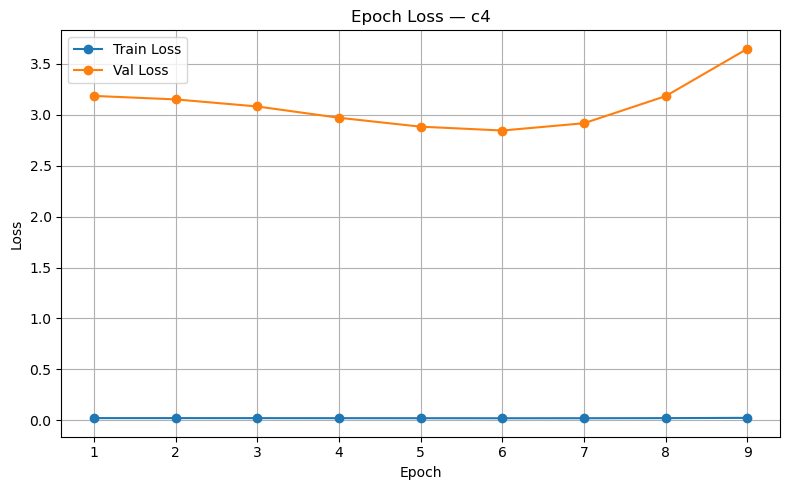

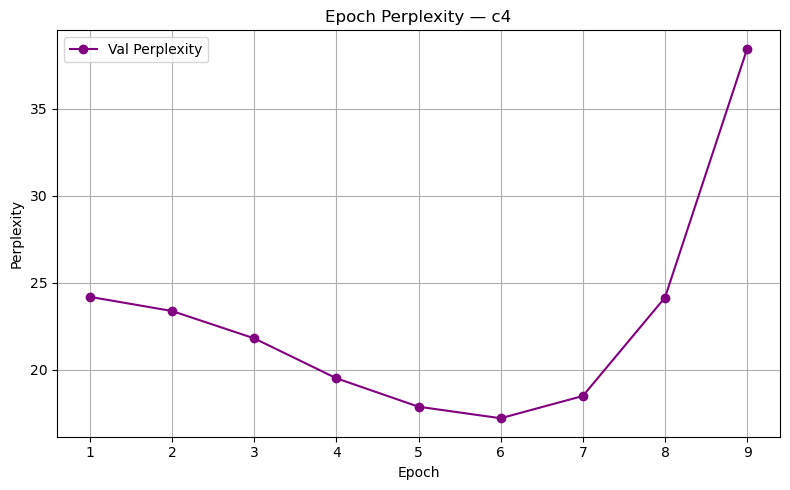

In [9]:
# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, marker='o', label="Val Loss")
plt.title("Epoch Loss — c4")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Perplexity
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(val_perplexities)+1), val_perplexities, marker='o', color='purple', label="Val Perplexity")
plt.title("Epoch Perplexity — c4")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()